In [1]:
from unityagents import UnityEnvironment
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64", no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, n_hidden=32):
        super(QNetwork, self).__init__()

        self.train_on_gpu = torch.cuda.is_available()
        if self.train_on_gpu:
            print("Using CUDA.")

        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.fc4 = nn.Linear(n_hidden, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [6]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 0.003
LR = 0.0005
UPDATE_EVERY = 4

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
import random
from collections import namedtuple, deque

import torch.optim as optim

class Agent():
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps = 0.0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)

        self.optimizer.zero_grad()

        loss.backward()

        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [10]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

n_episodes = 1200
max_t = 700
eps_decay = 0.99
eps_start = 1.0
eps_end = 0.01
score = 0
scores = []
scores_window = deque(maxlen=100)
eps = eps_start

for i_eps in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    for t in range(max_t):
        action = agent.act(state, eps)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        agent.step(state, action, reward, next_state, done)
        score += reward
        state = next_state
        if done:
            break
    scores_window.append(score)
    scores.append(score)
    eps = max(eps_end, eps_decay*eps)
    
    if i_eps % 100 == 0:
        print('Episode {}\tAverage Score: {:.2f}\n'.format(i_eps, np.mean(scores_window)), end="")
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

    if np.mean(scores_window) >= 13.0:
        print('Episode {}\tAverage Score: {:.2f}\n'.format(i_eps, np.mean(scores_window)))
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        break

Using CUDA.
Using CUDA.
Episode 100	Average Score: 2.39
Episode 200	Average Score: 8.99
Episode 300	Average Score: 11.67
Episode 383	Average Score: 13.05



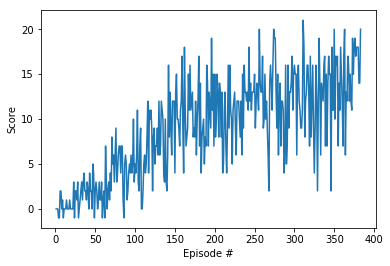

In [11]:
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

In [12]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
scores = []
for i in range(100):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    while True:
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward
        state = next_state
        if done:
            break
    scores.append(score)
    print("Episode " + str(i) + ": " + str(score))
ss = sum(scores)
ls = len(scores)
a_s = ss/ls
print("Average score over 100 episodes: " + str(a_s))

Episode 0: 19.0
Episode 1: 22.0
Episode 2: 17.0
Episode 3: 17.0
Episode 4: 14.0
Episode 5: 12.0
Episode 6: 8.0
Episode 7: 15.0
Episode 8: 17.0
Episode 9: 0.0
Episode 10: 19.0
Episode 11: 5.0
Episode 12: 16.0
Episode 13: 15.0
Episode 14: 14.0
Episode 15: 11.0
Episode 16: 12.0
Episode 17: 16.0
Episode 18: 16.0
Episode 19: 22.0
Episode 20: 13.0
Episode 21: 17.0
Episode 22: 14.0
Episode 23: 16.0
Episode 24: 8.0
Episode 25: 10.0
Episode 26: 16.0
Episode 27: 10.0
Episode 28: 17.0
Episode 29: 3.0
Episode 30: 15.0
Episode 31: 13.0
Episode 32: 16.0
Episode 33: 14.0
Episode 34: 16.0
Episode 35: 16.0
Episode 36: 3.0
Episode 37: 16.0
Episode 38: 27.0
Episode 39: 13.0
Episode 40: 16.0
Episode 41: 15.0
Episode 42: 13.0
Episode 43: 21.0
Episode 44: 14.0
Episode 45: 9.0
Episode 46: 20.0
Episode 47: 6.0
Episode 48: 16.0
Episode 49: 17.0
Episode 50: 14.0
Episode 51: 17.0
Episode 52: 21.0
Episode 53: 13.0
Episode 54: 3.0
Episode 55: 7.0
Episode 56: 18.0
Episode 57: 10.0
Episode 58: 18.0
Episode 59: 9.0
E

In [13]:
env.close()